# Statistical Analysis

## Relevant Imports

In [22]:
import pandas as pd
import numpy as np
# Plot histograms for sentiment_score and Close price
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from collections import Counter
import re
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
import gensim
from gensim import corpora

## Preprocessing

In [23]:
filepath_numerical = '../../dataset_final/FinSen_S&P500/S&P500_numerical.csv'
filepath_sentiment = '../../dataset_final/FinSen_S&P500/FinSen_text_annotated.csv'

In [24]:
data_num = pd.read_csv(filepath_numerical)
data_num.head()

,Date,Open,Close,High,Volume
0,2023-07-14,4514.60,4505.41,4527.75,3.647450e+09
1,2023-07-13,4491.50,4510.04,4517.37,3.839530e+09
2,2023-07-12,4467.68,4472.16,4488.33,3.920290e+09
3,2023-07-11,4415.54,4439.25,4443.64,3.624220e+09
4,2023-07-10,4394.22,4409.52,4412.60,3.429600e+09


In [25]:
data_sent = pd.read_csv(filepath_sentiment)
data_sent.head()

,Unnamed: 0,Title,Tag,Time,Content,sentiment_score
0,0,"TSX Slightly Down, Books Weekly Gains",Stock Market,16/07/2023,"TSX Slightly Down, Books Weekly GainsUnited St...",0.13
1,1,UnitedHealth Hits 4-week High,stocks,15/07/2023,UnitedHealth Hits 4-week HighUnited States sto...,0.62
2,2,Cisco Systems Hits 4-week Low,stocks,15/07/2023,Cisco Systems Hits 4-week LowUnited States sto...,-0.43
3,3,AT&T Hits All-time Low,stocks,15/07/2023,AT&T Hits All-time LowUnited States stocksAT&T...,-0.28
4,4,Microsoft Hits 4-week High,stocks,15/07/2023,Microsoft Hits 4-week HighUnited States stocks...,0.60


In [26]:
if 'Unnamed: 0' in data_sent.columns:
    data_sent = data_sent.drop(columns=['Unnamed: 0'])
data_sent.rename(columns={'Time': 'Date'}, inplace=True)
data_sent.head()

,Title,Tag,Date,Content,sentiment_score
0,"TSX Slightly Down, Books Weekly Gains",Stock Market,16/07/2023,"TSX Slightly Down, Books Weekly GainsUnited St...",0.13
1,UnitedHealth Hits 4-week High,stocks,15/07/2023,UnitedHealth Hits 4-week HighUnited States sto...,0.62
2,Cisco Systems Hits 4-week Low,stocks,15/07/2023,Cisco Systems Hits 4-week LowUnited States sto...,-0.43
3,AT&T Hits All-time Low,stocks,15/07/2023,AT&T Hits All-time LowUnited States stocksAT&T...,-0.28
4,Microsoft Hits 4-week High,stocks,15/07/2023,Microsoft Hits 4-week HighUnited States stocks...,0.60


In [27]:
data_sent.value_counts

<bound method DataFrame.value_counts of                                                    Title               Tag  \
0                  TSX Slightly Down, Books Weekly Gains      Stock Market   
1                          UnitedHealth Hits 4-week High            stocks   
2                          Cisco Systems Hits 4-week Low            stocks   
3                                 AT&T Hits All-time Low            stocks   
4                             Microsoft Hits 4-week High            stocks   
...                                                  ...               ...   
15529  United States GDP Rises 0.6 percent in the fir...   GDP Growth Rate   
15530  Consumer Price Index 2.6 percent higher than i...    Inflation Rate   
15531  U.S. Federal Reserve Kept Rates Unchanged at 5...     Interest Rate   
15532              Trade Deficit Increases in March 2007  Balance of Trade   
15533  Blackstone boosts IPO after Beijing takes $3bn...              News   

             Date      

In [28]:
data_sent = data_sent.drop_duplicates(subset=['Title', 'Content'])
data_sent.value_counts

<bound method DataFrame.value_counts of                                                    Title               Tag  \
0                  TSX Slightly Down, Books Weekly Gains      Stock Market   
1                          UnitedHealth Hits 4-week High            stocks   
2                          Cisco Systems Hits 4-week Low            stocks   
3                                 AT&T Hits All-time Low            stocks   
4                             Microsoft Hits 4-week High            stocks   
...                                                  ...               ...   
15529  United States GDP Rises 0.6 percent in the fir...   GDP Growth Rate   
15530  Consumer Price Index 2.6 percent higher than i...    Inflation Rate   
15531  U.S. Federal Reserve Kept Rates Unchanged at 5...     Interest Rate   
15532              Trade Deficit Increases in March 2007  Balance of Trade   
15533  Blackstone boosts IPO after Beijing takes $3bn...              News   

             Date      

## Merge Dataframes

In [29]:
# Aggregate sentiment scores by summing them up for each date
data_sent_aggregated = (
    data_sent.groupby('Date', as_index=False)
    .agg({'sentiment_score': 'sum'})
)

# Round the sentiment_score to two decimal places
data_sent_aggregated['sentiment_score'] = data_sent_aggregated['sentiment_score'].round(2)

# Merge aggregated scores back into the original DataFrame
data_sent = data_sent.drop(columns=['sentiment_score'])  # Drop original sentiment_score column
data_sent = data_sent.merge(data_sent_aggregated, on='Date', how='left')  # Add aggregated column

print(data_sent)


                                                   Title               Tag  \
0                  TSX Slightly Down, Books Weekly Gains      Stock Market   
1                          UnitedHealth Hits 4-week High            stocks   
2                          Cisco Systems Hits 4-week Low            stocks   
3                                 AT&T Hits All-time Low            stocks   
4                             Microsoft Hits 4-week High            stocks   
...                                                  ...               ...   
15478  United States GDP Rises 0.6 percent in the fir...   GDP Growth Rate   
15479  Consumer Price Index 2.6 percent higher than i...    Inflation Rate   
15480  U.S. Federal Reserve Kept Rates Unchanged at 5...     Interest Rate   
15481              Trade Deficit Increases in March 2007  Balance of Trade   
15482  Blackstone boosts IPO after Beijing takes $3bn...              News   

             Date                                            Co

In [30]:
# Ensure Date columns are in datetime format
data_num['Date'] = pd.to_datetime(data_num['Date'])
data_sent['Date'] = pd.to_datetime(data_sent['Date'])

# Merge the dataframes on the 'Date' column
data_merged = pd.merge(data_num, data_sent, on='Date', how='inner')
# After this step, df_merged will have:
# Date, Title, Content, Tag, sentiment_score, Open, High, Close, Volume, etc.


/var/folders/pd/35sqmnx90k31hxsfkmzt115m000cd0/T/ipykernel_56254/2012155046.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_sent['Date'] = pd.to_datetime(data_sent['Date'])


In [31]:
data_merged.head()

,Date,Open,Close,High,Volume,Title,Tag,Content,sentiment_score
0,2023-07-14,4514.6,4505.41,4527.75,3.647450e+09,US Budget Deficit Widens More than Expected in...,Government Budget Value,US Budget Deficit Widens More than Expected in...,1.02
1,2023-07-14,4514.6,4505.41,4527.75,3.647450e+09,Visa Hits 24-week High,stocks,Visa Hits 24-week HighUnited States stocksVisa...,1.02
2,2023-07-14,4514.6,4505.41,4527.75,3.647450e+09,Amazon Hits 43-week High,stocks,Amazon Hits 43-week HighUnited States stocksAm...,1.02
3,2023-07-14,4514.6,4505.41,4527.75,3.647450e+09,10-Year Treasury Yield Falls for 4th Session,Government Bond 10Y,10-Year Treasury Yield Falls for 4th SessionUn...,1.02
4,2023-07-14,4514.6,4505.41,4527.75,3.647450e+09,DXY Approaches 100,Currency,DXY Approaches 100United States CurrencyThe do...,1.02
5,2023-07-14,4514.6,4505.41,4527.75,3.647450e+09,US Core PPI Rises Less than Expected,Core Producer Prices MoM,US Core PPI Rises Less than ExpectedUnited Sta...,1.02
6,2023-07-14,4514.6,4505.41,4527.75,3.647450e+09,Progressive earnings below expectations at 0.5...,Earnings,Progressive earnings below expectations at 0.5...,1.02
7,2023-07-14,4514.6,4505.41,4527.75,3.647450e+09,PepsiCo earnings above expectations at 2.09 USD,Earnings,PepsiCo earnings above expectations at 2.09 US...,1.02
8,2023-07-13,4491.5,4510.04,4517.37,3.839530e+09,US Mortgage Applications Rise 0.9%: MBA,Mortgage Applications,US Mortgage Applications Rise 0.9%: MBAUnited ...,-0.14
9,2023-07-13,4491.5,4510.04,4517.37,3.839530e+09,Dollar Languishes Ahead of Key Inflation Report,Currency,Dollar Languishes Ahead of Key Inflation Repor...,-0.14


In [48]:

# Ensure filtered_data is a full copy of data_merged
filtered_data = data_merged.copy()

# Merge all rows for the same date into one row
merged_data = filtered_data.groupby('Date', as_index=False).agg({
    'Open': 'first',
    'Close': 'first',
    'High': 'first',
    'Volume': 'sum',  # Summing volumes for the same date
    'Title': lambda x: ', '.join(x),  # Joining titles with commas
    'Tag': lambda x: ', '.join(x),  # Joining tags with commas
    'Content': lambda x: ', '.join(x),  # Joining content with commas
    'sentiment_score': 'first'  # Assuming sentiment score is already aggregated
})

# Display or save the result
merged_data.head(10)


,Date,Open,Close,High,Volume,Title,Tag,Content,sentiment_score
0,2007-06-04,1536.28,1539.18,1540.53,5.477860e+09,"Trade Deficit Increases in March 2007, Blackst...","Balance of Trade, News",Trade Deficit Increases in March 2007United St...,0.03
1,2007-06-06,1530.56,1517.38,1530.56,1.482095e+10,"Nonfarm payroll employment increased by 157,00...","Unemployment Rate, Balance of Trade, GDP Growt...","Nonfarm payroll employment increased by 157,00...",0.01
2,2007-06-21,1512.50,1522.18,1522.90,3.161110e+09,US Economy is expanding after Q1 slowdown,GDP Growth Rate,US Economy is expanding after Q1 slowdownUnite...,0.03
3,2007-06-26,1497.68,1492.89,1506.11,3.398530e+09,Consumer Confidence and Housing Weaken in US,GDP Growth Rate,Consumer Confidence and Housing Weaken in USUn...,-0.66
4,2007-06-28,1506.31,1505.70,1514.83,3.006710e+09,Fed keeps the federal funds rate at 5-1/4 percent,Interest Rate,Fed keeps the federal funds rate at 5-1/4 perc...,0.16
5,2007-07-05,1524.85,1525.40,1526.56,2.622950e+09,U.S. ISM Services Index Reached 14-Month High ...,News,U.S. ISM Services Index Reached 14-Month High ...,0.66
6,2007-07-06,1524.95,1530.43,1532.40,2.441520e+09,US June unemployment rate unchanged at 4.5%,Unemployment Rate,US June unemployment rate unchanged at 4.5%Uni...,-0.02
7,2007-07-10,1531.84,1510.11,1531.84,3.244280e+09,"U.S. Growth, Easing Inflation to Follow Fed `S...",Inflation Rate,"U.S. Growth, Easing Inflation to Follow Fed `S...",0.00
8,2007-07-12,1518.73,1547.69,1547.92,3.489600e+09,US trade deficit increases to $60.0 billion in...,Balance of Trade,US trade deficit increases to $60.0 billion in...,-0.02
9,2007-07-18,1549.19,1546.17,1549.19,3.609220e+09,Fed chief acknowledges credit fears,Stock Market,Fed chief acknowledges credit fearsUnited Stat...,-0.11


In [52]:
# Import necessary library
import numpy as np

# 1. Log Returns
# Daily log return (Close to Open)
merged_data['log_return_daily'] = np.log(merged_data['Close'] / merged_data['Open'])

# Overnight log return (Open of tomorrow to Close of today)
merged_data['log_return_overnight'] = np.log(merged_data['Open'].shift(-1) / merged_data['Close'])

# 2. Volatility
# Daily range as a measure of volatility
merged_data['daily_volatility'] = (merged_data['High'] - merged_data['Open']) / merged_data['Open']

# Rolling standard deviation of daily returns (e.g., 7-day rolling window)
merged_data['rolling_volatility_7'] = merged_data['log_return_daily'].rolling(window=7).std()

# 3. Moving Averages
# Moving average of closing prices
merged_data['moving_avg_close_7'] = merged_data['Close'].rolling(window=7).mean()
merged_data['moving_avg_close_14'] = merged_data['Close'].rolling(window=14).mean()

# Moving average of sentiment scores
merged_data['moving_avg_sentiment_7'] = merged_data['sentiment_score'].rolling(window=7).mean()
merged_data['moving_avg_sentiment_14'] = merged_data['sentiment_score'].rolling(window=14).mean()

# 4. Rolling Sentiment
# Rolling mean and standard deviation of sentiment scores
merged_data['rolling_sentiment_mean_7'] = merged_data['sentiment_score'].rolling(window=7).mean()
merged_data['rolling_sentiment_std_7'] = merged_data['sentiment_score'].rolling(window=7).std()

# 5. Lagged Sentiment
# Lag sentiment by 1 day
merged_data['sentiment_lag_1'] = merged_data['sentiment_score'].shift(1)
# Lag sentiment by 2 days
merged_data['sentiment_lag_2'] = merged_data['sentiment_score'].shift(2)

# 6. Interaction Features
# Interaction between sentiment and daily volatility
merged_data['sentiment_volatility_interaction'] = merged_data['sentiment_score'] * merged_data['daily_volatility']

# Drop NaNs created by rolling or shifting
merged_data = merged_data.dropna()

merged_data.head()


,Date,Open,Close,High,Volume,Title,Tag,Content,sentiment_score,intraday_return,...,rolling_volatility_7,moving_avg_close_7,moving_avg_close_14,moving_avg_sentiment_7,moving_avg_sentiment_14,rolling_sentiment_mean_7,rolling_sentiment_std_7,sentiment_lag_1,sentiment_lag_2,sentiment_volatility_interaction
13,2007-07-31,1473.90,1455.27,1488.30,4.524520e+09,US core inflation was up by 0.1 percent in June,Inflation Rate,US core inflation was up by 0.1 percent in Jun...,0.00,-0.012640,...,0.014557,1502.702857,1510.862857,-0.052857,-0.011429,-0.052857,0.220961,0.34,-0.38,0.000000
14,2007-08-01,1455.18,1465.81,1468.38,5.256780e+09,U.S. Companies added the smallest number of jo...,Unemployment Rate,U.S. Companies added the smallest number of jo...,-0.15,0.007305,...,0.014895,1496.374286,1505.622143,-0.074286,-0.024286,-0.074286,0.222250,0.00,0.34,-0.001361
15,2007-08-07,1467.61,1476.70,1488.30,4.909390e+09,US Federal Reserve keeps interest rates unchan...,Interest Rate,US Federal Reserve keeps interest rates unchan...,0.00,0.006194,...,0.012276,1486.232857,1502.716429,-0.071429,-0.025000,-0.071429,0.223191,-0.15,0.00,0.000000
16,2007-08-10,1453.08,1453.64,1462.02,5.345780e+09,Stock Markets Fall Worldwide! Recession?,Stock Market,Stock Markets Fall Worldwide! Recession?United...,-0.67,0.000385,...,0.012409,1473.014286,1497.820714,-0.151429,-0.075000,-0.151429,0.319084,0.00,-0.15,-0.004122
17,2007-08-13,1453.42,1452.92,1466.29,3.696280e+09,Goldman Sachs fights back by putting $3 billio...,Stock Market,Goldman Sachs fights back by putting $3 billio...,-0.20,-0.000344,...,0.011906,1463.705714,1494.965714,-0.151429,-0.042143,-0.151429,0.319084,-0.67,0.00,-0.001771


In [62]:
# Compute the correlation matrix for numerical columns
numerical_columns = [ 'sentiment_score', 'intraday_return', 
    'overnight_return', 'log_return_daily', 'log_return_overnight', 
    'daily_volatility']

''''rolling_volatility_7', 'moving_avg_close_7', 
    'moving_avg_close_14', 'moving_avg_sentiment_7', 'moving_avg_sentiment_14',
    'rolling_sentiment_mean_7', 'rolling_sentiment_std_7', 'sentiment_lag_1', 
    'sentiment_lag_2', 'sentiment_volatility_interaction' '''

correlation_matrix = merged_data[numerical_columns].corr()

# Save or display the correlation matrix
correlation_matrix.to_csv("correlation_matrix.csv")
print(correlation_matrix)


                      sentiment_score  intraday_return  overnight_return  \
sentiment_score              1.000000         0.234176         -0.009502   
intraday_return              0.234176         1.000000         -0.131600   
overnight_return            -0.009502        -0.131600          1.000000   
log_return_daily             0.236045         0.999910         -0.130783   
log_return_overnight        -0.008215        -0.132220          0.999721   
daily_volatility             0.062827         0.689890         -0.127601   

                      log_return_daily  log_return_overnight  daily_volatility  
sentiment_score               0.236045             -0.008215          0.062827  
intraday_return               0.999910             -0.132220          0.689890  
overnight_return             -0.130783              0.999721         -0.127601  
log_return_daily              1.000000             -0.131318          0.683002  
log_return_overnight         -0.131318              1.000000  

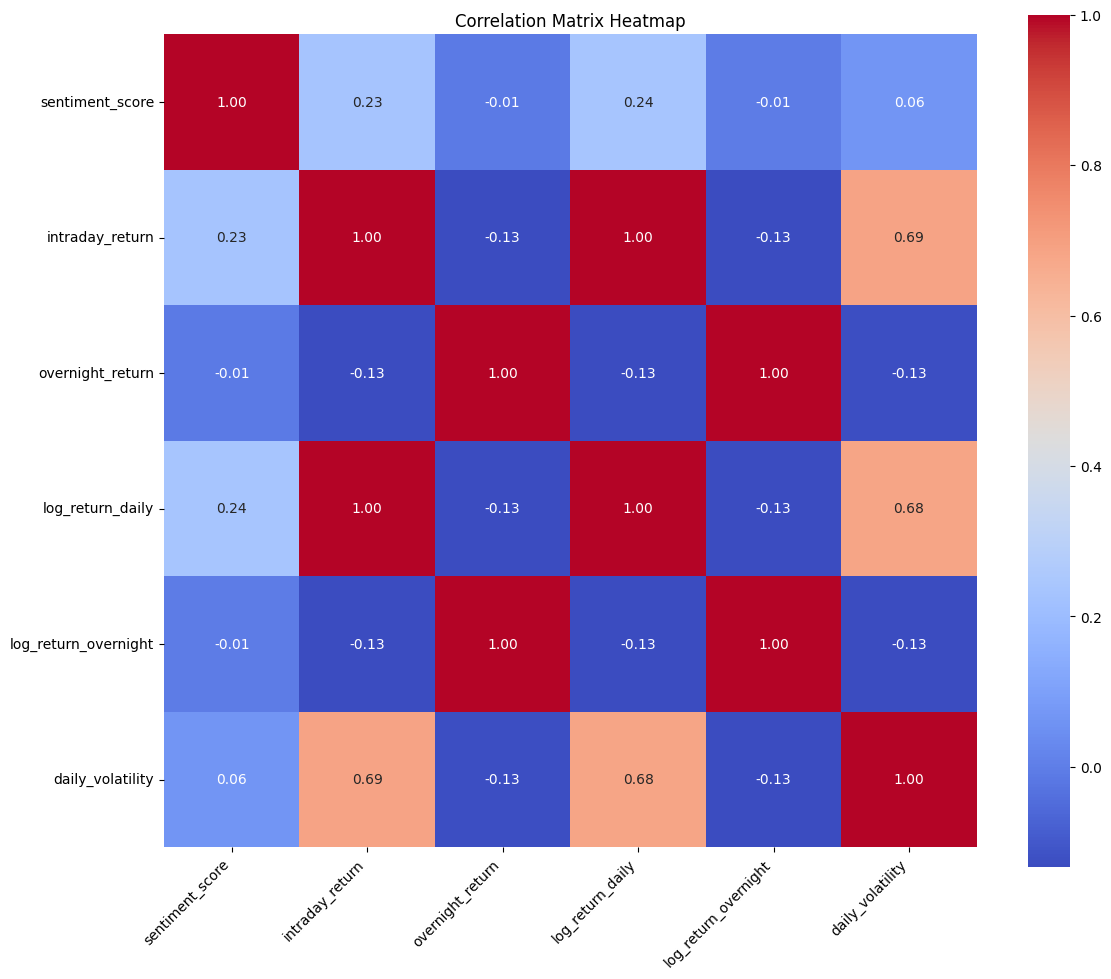

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Display the plot
plt.show()


In [65]:
# Calculate the two types of movements
merged_data['movement_open_close_lag'] = merged_data['Open'] - merged_data['Close'].shift(1)
merged_data['movement_close_close_lag'] = merged_data['Close'] - merged_data['Close'].shift(1)

# Lagged sentiment score (Sentiment on day x-1)
merged_data['sentiment_lag_1'] = merged_data['sentiment_score'].shift(1)

# Drop rows with NaN caused by lagging
valid_data = merged_data.dropna(subset=['sentiment_lag_1', 'movement_open_close_lag', 'movement_close_close_lag'])


# Check if we have enough data points
if len(valid_data) > 1:
    # Correlation between lagged sentiment and Movement 1
    corr_open_close_lag, pval_open_close_lag = pearsonr(
        valid_data['sentiment_lag_1'],
        valid_data['movement_open_close_lag']
    )

    # Correlation between lagged sentiment and Movement 2
    corr_close_close_lag, pval_close_close_lag = pearsonr(
        valid_data['sentiment_lag_1'],
        valid_data['movement_close_close_lag']
    )

    # Print the results
    print(f"Correlation (Lagged Sentiment vs Open-Close Lag Movement): {corr_open_close_lag}, p-value: {pval_open_close_lag}")
    print(f"Correlation (Lagged Sentiment vs Close-Close Lag Movement): {corr_close_close_lag}, p-value: {pval_close_close_lag}")
else:
    print("Not enough data points after dropping NaNs to compute correlations.")


Correlation (Lagged Sentiment vs Open-Close Lag Movement): -0.021354114553286677, p-value: 0.2587393083875496
Correlation (Lagged Sentiment vs Close-Close Lag Movement): -0.05780414531057465, p-value: 0.0022181506770756346


In [66]:
# Compute rolling averages for sentiment score
merged_data['rolling_sentiment_mean_7'] = merged_data['sentiment_score'].rolling(window=7).mean()
merged_data['rolling_sentiment_mean_14'] = merged_data['sentiment_score'].rolling(window=14).mean()

# Compute rolling averages for movements
merged_data['rolling_movement_open_close_7'] = merged_data['movement_open_close_lag'].rolling(window=7).mean()
merged_data['rolling_movement_open_close_14'] = merged_data['movement_open_close_lag'].rolling(window=14).mean()

merged_data['rolling_movement_close_close_7'] = merged_data['movement_close_close_lag'].rolling(window=7).mean()
merged_data['rolling_movement_close_close_14'] = merged_data['movement_close_close_lag'].rolling(window=14).mean()

# Drop rows with NaN caused by rolling calculations
valid_data = merged_data.dropna(subset=[
    'rolling_sentiment_mean_7', 'rolling_sentiment_mean_14',
    'rolling_movement_open_close_7', 'rolling_movement_open_close_14',
    'rolling_movement_close_close_7', 'rolling_movement_close_close_14'
])

# Test correlations for 7-day rolling sentiment
corr_open_close_7, pval_open_close_7 = pearsonr(
    valid_data['rolling_sentiment_mean_7'],
    valid_data['rolling_movement_open_close_7']
)

corr_close_close_7, pval_close_close_7 = pearsonr(
    valid_data['rolling_sentiment_mean_7'],
    valid_data['rolling_movement_close_close_7']
)

# Test correlations for 14-day rolling sentiment
corr_open_close_14, pval_open_close_14 = pearsonr(
    valid_data['rolling_sentiment_mean_14'],
    valid_data['rolling_movement_open_close_14']
)

corr_close_close_14, pval_close_close_14 = pearsonr(
    valid_data['rolling_sentiment_mean_14'],
    valid_data['rolling_movement_close_close_14']
)

# Print results
print(f"7-day Rolling Sentiment vs Rolling Open-Close (7-day): Correlation: {corr_open_close_7}, p-value: {pval_open_close_7}")
print(f"7-day Rolling Sentiment vs Rolling Close-Close (7-day): Correlation: {corr_close_close_7}, p-value: {pval_close_close_7}")

print(f"14-day Rolling Sentiment vs Rolling Open-Close (14-day): Correlation: {corr_open_close_14}, p-value: {pval_open_close_14}")
print(f"14-day Rolling Sentiment vs Rolling Close-Close (14-day): Correlation: {corr_close_close_14}, p-value: {pval_close_close_14}")


7-day Rolling Sentiment vs Rolling Open-Close (7-day): Correlation: 0.31044578725232475, p-value: 2.634489925994026e-63
7-day Rolling Sentiment vs Rolling Close-Close (7-day): Correlation: 0.37260569019728457, p-value: 1.7684103321836373e-92
14-day Rolling Sentiment vs Rolling Open-Close (14-day): Correlation: 0.34485715658698407, p-value: 1.2522935808866044e-78
14-day Rolling Sentiment vs Rolling Close-Close (14-day): Correlation: 0.4008375183091875, p-value: 4.8938944682352414e-108


In [50]:
import numpy as np
from scipy.stats import pearsonr

# 1. Calculate intraday return (Close - Open) / Open
merged_data['intraday_return'] = (merged_data['Close'] - merged_data['Open']) / merged_data['Open']

# Drop rows with NaN in sentiment_score or intraday_return
intraday_df = merged_data[['sentiment_score', 'intraday_return']].dropna()

# Correlate intraday_return with sentiment_score
intraday_corr, intraday_pval = pearsonr(
    intraday_df['sentiment_score'],
    intraday_df['intraday_return']
)

print(f"Correlation between sentiment score and intraday return (Close - Open): {intraday_corr}")
print(f"P-value: {intraday_pval}")

# 2. Calculate overnight return (Open of Tomorrow - Close of Today) / Close of Today
merged_data['overnight_return'] = (merged_data['Open'].shift(-1) - merged_data['Close']) / merged_data['Close']

# Drop rows with NaN in sentiment_score or overnight_return
overnight_df = merged_data[['sentiment_score', 'overnight_return']].dropna()

# Correlate today's sentiment_score with tomorrow's overnight_return
overnight_corr, overnight_pval = pearsonr(
    overnight_df['sentiment_score'],
    overnight_df['overnight_return']
)

print(f"Correlation between today's sentiment score and overnight return (Open of Tomorrow - Close of Today): {overnight_corr}")
print(f"P-value: {overnight_pval}")


Correlation between sentiment score and intraday return (Close - Open): 0.23343931597546946
P-value: 3.8960807964344076e-36
Correlation between today's sentiment score and overnight return (Open of Tomorrow - Close of Today): -0.009436567078297268
P-value: 0.6168760227856885


## Statistical Summary

Summary Statistics:
        sentiment_score          Open          High         Close        Volume
count     15210.000000  15210.000000  15210.000000  15210.000000  1.521000e+04
mean          0.011536   3247.925329   3269.228025   3249.017142  4.265330e+09
std           1.046219    952.655030    960.022574    953.492994  1.028215e+09
min          -3.490000    684.030000    699.090000    683.380000  1.219310e+09
25%          -0.590000   2469.427500   2480.370000   2472.765000  3.611510e+09
50%          -0.010000   3323.160000   3341.050000   3315.570000  4.078870e+09
75%           0.590000   4126.430000   4148.560000   4129.790000  4.689970e+09
max           4.400000   4804.500000   4818.620000   4796.560000  1.145623e+10


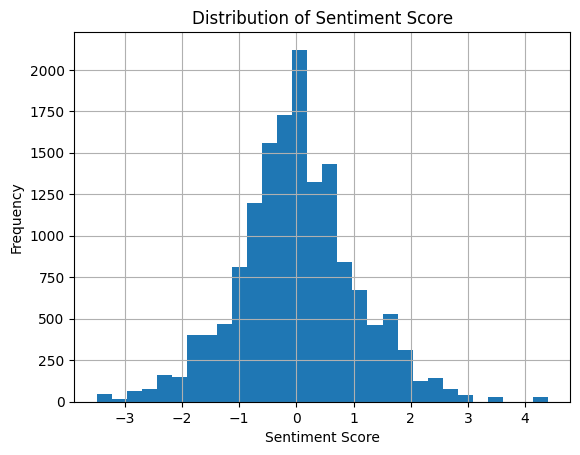

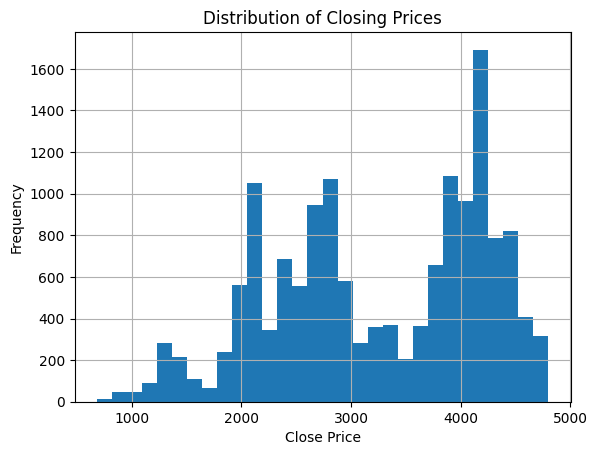

In [11]:
# Basic statistical analysis of numerical features
print("Summary Statistics:\n", data_merged[['sentiment_score', 'Open', 'High', 'Close', 'Volume']].describe())
plt.figure()
data_merged['sentiment_score'].hist(bins=30)
plt.title('Distribution of Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

plt.figure()
data_merged['Close'].hist(bins=30)
plt.title('Distribution of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()


## Correlation Analysis

Correlation Matrix:
                  sentiment_score      Open      High     Close    Volume
sentiment_score         1.000000  0.115081  0.117640  0.125435 -0.143784
Open                    0.115081  1.000000  0.999729  0.999287  0.175242
High                    0.117640  0.999729  1.000000  0.999640  0.182120
Close                   0.125435  0.999287  0.999640  1.000000  0.172656
Volume                 -0.143784  0.175242  0.182120  0.172656  1.000000


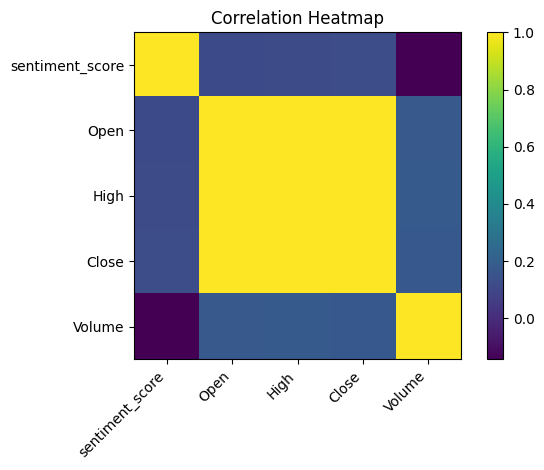

In [13]:
# Select numeric columns for correlation
numeric_cols = ['sentiment_score', 'Open', 'High', 'Close', 'Volume']
corr_matrix = data_merged[numeric_cols].corr()

print("Correlation Matrix:\n", corr_matrix)


plt.figure()
plt.imshow(corr_matrix, cmap='viridis', interpolation='nearest')
plt.title('Correlation Heatmap')
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.tight_layout()
plt.show()


## Causality Testing

In [15]:
# Compute daily returns from Close price if not already done
data_merged['Returns'] = data_merged['Close'].pct_change()
data_merged.dropna(subset=['Returns', 'sentiment_score'], inplace=True)

data = data_merged[['Returns', 'sentiment_score']].dropna()
max_lags = 5

results = grangercausalitytests(data[['Returns', 'sentiment_score']], maxlag=max_lags, verbose=False)

for lag in results.keys():
    # The first element of results[lag] is a dictionary with the test results
    test_results_dict = results[lag][0]
    print(f"\nLag {lag}:")
    for test_type, test_result in test_results_dict.items():
        # test_result is a tuple of (test_statistic, p_value, degrees_of_freedom, ...)
        # The structure varies slightly by test type
        print(f"  {test_type}:")
        print(f"    Test Statistic: {test_result[0]}")
        print(f"    p-value: {test_result[1]}")
        # Depending on the test, you may have 2 or 4 elements in test_result
        # Typically:
        # ssr_ftest, params_ftest: (F_statistic, p_value, df_denom, df_num)
        # ssr_chi2test, lrtest: (chi2_statistic or lr_statistic, p_value, df)
        
        # If it's an F-type test:
        if test_type in ['ssr_ftest', 'params_ftest']:
            print(f"    df_denom: {test_result[2]}")
            print(f"    df_num: {test_result[3]}")
        else:
            # lrtest and ssr_chi2test return 3 values: stat, p_value, df
            print(f"    df: {test_result[2]}")



Lag 1:
  ssr_ftest:
    Test Statistic: 154.3954650840458
    p-value: 2.815573517728071e-35
    df_denom: 15205.0
    df_num: 1
  ssr_chi2test:
    Test Statistic: 154.4259278525596
    p-value: 1.8691648656514337e-35
    df: 1
  lrtest:
    Test Statistic: 153.64715510542737
    p-value: 2.765922440060534e-35
    df: 1
  params_ftest:
    Test Statistic: 154.39546508403612
    p-value: 2.815573517739994e-35
    df_denom: 15205.0
    df_num: 1.0

Lag 2:
  ssr_ftest:
    Test Statistic: 79.67343151264213
    p-value: 3.78754738859515e-35
    df_denom: 15202.0
    df_num: 2
  ssr_chi2test:
    Test Statistic: 159.39927286051162
    p-value: 2.437180466270242e-35
    df: 2
  lrtest:
    Test Statistic: 158.56965620501433
    p-value: 3.6900874327518956e-35
    df: 2
  params_ftest:
    Test Statistic: 79.6734315126422
    p-value: 3.78754738859515e-35
    df_denom: 15202.0
    df_num: 2.0

Lag 3:
  ssr_ftest:
    Test Statistic: 54.1444367021973
    p-value: 8.372206498194948e-35
    df

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


## Volatility Summary Statistics

Volatility Summary Statistics:
 count    15189.000000
mean         0.004066
std          0.004711
min          0.000000
25%          0.001522
50%          0.002841
75%          0.005060
max          0.051497
Name: Volatility, dtype: float64

Count of Days by Volatility Level:
 Volatility_Level
Medium    7588
Low       3801
High      3800
Name: count, dtype: int64


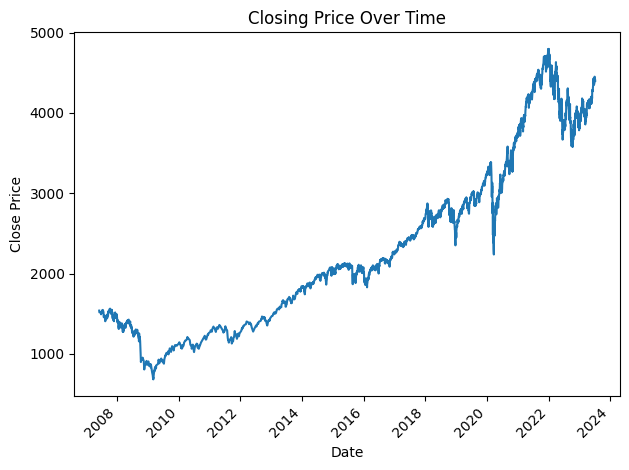

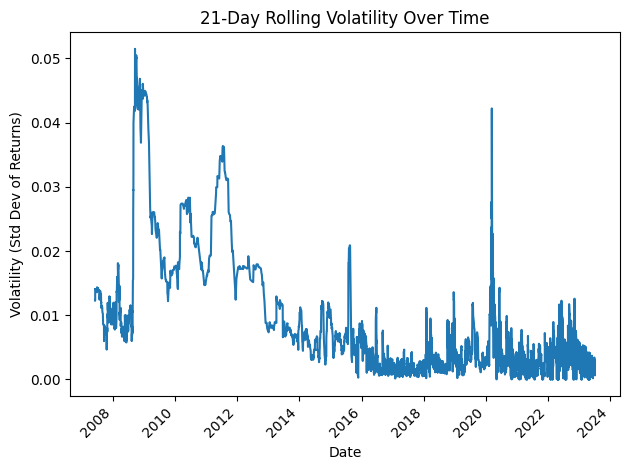

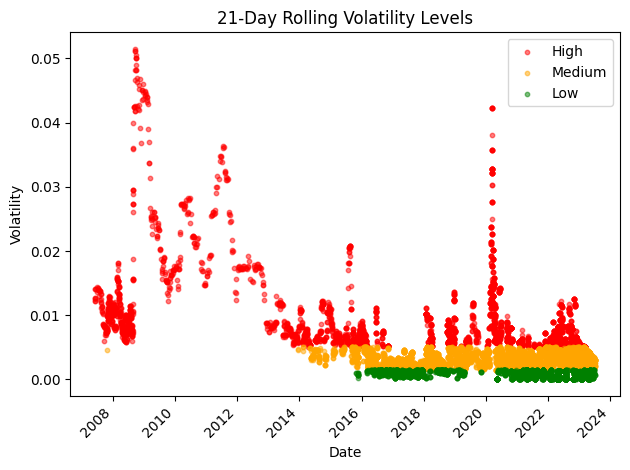

In [16]:
# Ensure Returns column is computed (if not already)
if 'Returns' not in data_merged.columns:
    data_merged['Returns'] = data_merged['Close'].pct_change()

# Compute a rolling volatility measure (21-day rolling standard deviation of returns)
window_size = 21  # This can be adjusted
data_merged['Volatility'] = data_merged['Returns'].rolling(window=window_size).std()

# Drop any rows where Volatility could not be computed due to insufficient data at the start
data_merged.dropna(subset=['Volatility'], inplace=True)

# Summary statistics of Volatility
print("Volatility Summary Statistics:\n", data_merged['Volatility'].describe())

# Identify volatile vs. stable periods
# For example, define volatile as the top 25% of volatility values and stable as the bottom 25%
q75 = data_merged['Volatility'].quantile(0.75)
q25 = data_merged['Volatility'].quantile(0.25)

data_merged['Volatility_Level'] = np.where(data_merged['Volatility'] >= q75, 'High', 
                                 np.where(data_merged['Volatility'] <= q25, 'Low', 'Medium'))

# Print how many days fall into each category
print("\nCount of Days by Volatility Level:\n", data_merged['Volatility_Level'].value_counts())

# Plot closing prices over time
plt.figure()
plt.plot(data_merged['Date'], data_merged['Close'])
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot volatility over time
plt.figure()
plt.plot(data_merged['Date'], data_merged['Volatility'])
plt.title(f'{window_size}-Day Rolling Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (Std Dev of Returns)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Highlighting volatile vs stable periods could be done by marking them on the plot.
# For simplicity, we'll create separate plots or use color-coded markers.
plt.figure()
for level, color in zip(['High', 'Medium', 'Low'], ['red', 'orange', 'green']):
    subset = data_merged[data_merged['Volatility_Level'] == level]
    plt.scatter(subset['Date'], subset['Volatility'], label=level, alpha=0.5, s=10, c=color)

plt.title(f'{window_size}-Day Rolling Volatility Levels')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# This gives a visual and tabular idea of which periods were more volatile (High) and which were stable (Low).
# You can further inspect these periods by filtering df_merged based on Volatility_Level and then checking the news (Title, Content) for context.


## Analysis of top Volatility days

In [17]:
# Identify the top volatile and stable periods
# We'll focus on "High" (most volatile) and "Low" (most stable) periods
high_vol = data_merged[data_merged['Volatility_Level'] == 'High']
low_vol = data_merged[data_merged['Volatility_Level'] == 'Low']

# Sort these by Volatility descending to find the highest volatility days
high_vol = high_vol.sort_values(by='Volatility', ascending=False)
low_vol = low_vol.sort_values(by='Volatility', ascending=True)

print("Top 10 Highest Volatility Days:")
display(high_vol[['Date', 'Close', 'Volatility', 'Title', 'Content']].head(10))

print("\nTop 10 Lowest Volatility Days:")
display(low_vol[['Date', 'Close', 'Volatility', 'Title', 'Content']].head(10))

# Count word occurrences in the 'Title' or 'Content' during high volatility days
# to get a sense of common themes. (Simple textual analysis)
# Convert all text to lowercase and split by whitespace

# Combine all titles/content from high volatility days
all_high_titles = " ".join(high_vol['Title'].astype(str)).lower()
all_high_content = " ".join(high_vol['Content'].astype(str)).lower()

# Simple tokenization: remove non-alphabetic characters and split
tokens_titles = re.findall(r'\b[a-z]+\b', all_high_titles)
tokens_content = re.findall(r'\b[a-z]+\b', all_high_content)

title_word_freq = Counter(tokens_titles)
content_word_freq = Counter(tokens_content)

# Display the top 10 most common words in Titles and Content during high volatility
print("\nTop 10 most common words in Titles during high volatility periods:")
for word, freq in title_word_freq.most_common(10):
    print(f"{word}: {freq}")

print("\nTop 10 most common words in Content during high volatility periods:")
for word, freq in content_word_freq.most_common(10):
    print(f"{word}: {freq}")


Top 10 Highest Volatility Days:


,Date,Close,Volatility,Title,Content
14731,2008-09-16,1213.59,0.051497,Fed Keeps Rate at 2%,Fed Keeps Rate at 2%United States Interest Rat...
14730,2008-09-17,1156.39,0.051181,Bank Fears Hit Stocks,Bank Fears Hit StocksUnited States Stock Marke...
14732,2008-09-16,1213.59,0.051121,U.S. Stocks Drop for a Second Day,U.S. Stocks Drop for a Second DayUnited States...
14725,2008-10-01,1161.06,0.050495,U.S. Senate Approves $700 Billion Financial-Re...,U.S. Senate Approves $700 Billion Financial-Re...
14723,2008-10-03,1099.22,0.050119,"U.S. Payrolls Fell by 159,000","U.S. Payrolls Fell by 159,000United States Une..."
14722,2008-10-03,1099.22,0.050116,House passes $700 billion financial bailout,House passes $700 billion financial bailoutUni...
14724,2008-10-02,1114.28,0.050078,Will the Rescue Plan Help the U.S. Economy?,Will the Rescue Plan Help the U.S. Economy?Uni...
14726,2008-09-26,1213.27,0.048930,U.S. Economic Growth Slower,U.S. Economic Growth SlowerUnited States GDP G...
14728,2008-09-22,1207.08,0.048250,What’s Next for the United States?,What’s Next for the United States?United State...
14727,2008-09-22,1207.08,0.048250,Dollar Weakens Most Since Euro's 1999 Debut,Dollar Weakens Most Since Euro's 1999 DebutUni...



Top 10 Lowest Volatility Days:


,Date,Close,Volatility,Title,Content
2426,2022-08-04,4151.93,0.0,Vulcan Materials earnings below expectations a...,Vulcan Materials earnings below expectations a...
2629,2022-07-28,4072.42,0.0,T. Rowe Price earnings below expectations at 1...,T. Rowe Price earnings below expectations at 1...
2630,2022-07-28,4072.42,0.0,Baxter International earnings meet market expe...,Baxter International earnings meet market expe...
2631,2022-07-28,4072.42,0.0,Mastercard earnings above expectations at 2.56...,Mastercard earnings above expectations at 2.56...
2632,2022-07-28,4072.42,0.0,Reliance Steel & Aluminum earnings above expec...,Reliance Steel & Aluminum earnings above expec...
2633,2022-07-28,4072.42,0.0,Teleflex earnings above expectations at 3.39 USD,Teleflex earnings above expectations at 3.39 U...
2634,2022-07-28,4072.42,0.0,Masco earnings below expectations at 1.14 USD,Masco earnings below expectations at 1.14 USDU...
2635,2022-07-28,4072.42,0.0,Carlyle earnings above expectations at 1.17 USD,Carlyle earnings above expectations at 1.17 US...
2636,2022-07-28,4072.42,0.0,Kimco Realty earnings below expectations at -0...,Kimco Realty earnings below expectations at -0...
2637,2022-07-28,4072.42,0.0,Textron earnings below expectations at 0.81 USD,Textron earnings below expectations at 0.81 US...



Top 10 most common words in Titles during high volatility periods:
us: 1870
in: 913
at: 663
stocks: 512
to: 462
earnings: 445
s: 437
usd: 429
dollar: 423
expectations: 403

Top 10 most common words in Content during high volatility periods:
the: 14978
in: 8496
to: 6732
of: 6316
and: 5535
a: 4794
states: 4403
on: 3434
us: 3389
percent: 3005


In [18]:

# Ensure that nltk's stopwords are downloaded
# nltk.download('stopwords') # Uncomment if needed

stop_words = set(stopwords.words('english'))

# Combine all titles/content from high volatility days
all_high_titles = " ".join(high_vol['Title'].astype(str)).lower()
all_high_content = " ".join(high_vol['Content'].astype(str)).lower()

# Simple tokenization: remove non-alphabetic characters and split
tokens_titles = re.findall(r'\b[a-z]+\b', all_high_titles)
tokens_content = re.findall(r'\b[a-z]+\b', all_high_content)

# Filter out stopwords
filtered_titles = [word for word in tokens_titles if word not in stop_words]
filtered_content = [word for word in tokens_content if word not in stop_words]

title_word_freq = Counter(filtered_titles)
content_word_freq = Counter(filtered_content)

print("\nTop 10 most common words in Titles during high volatility periods (stopwords removed):")
for word, freq in title_word_freq.most_common(10):
    print(f"{word}: {freq}")

print("\nTop 10 most common words in Content during high volatility periods (stopwords removed):")
for word, freq in content_word_freq.most_common(10):
    print(f"{word}: {freq}")



Top 10 most common words in Titles during high volatility periods (stopwords removed):
us: 1870
stocks: 512
earnings: 445
usd: 429
dollar: 423
expectations: 403
u: 388
rise: 276
high: 255
week: 252

Top 10 most common words in Content during high volatility periods (stopwords removed):
states: 4403
us: 3389
percent: 3005
expectations: 1512
week: 1435
usd: 1408
market: 1405
year: 1380
month: 1370
rate: 1174


<Figure size 640x480 with 0 Axes>

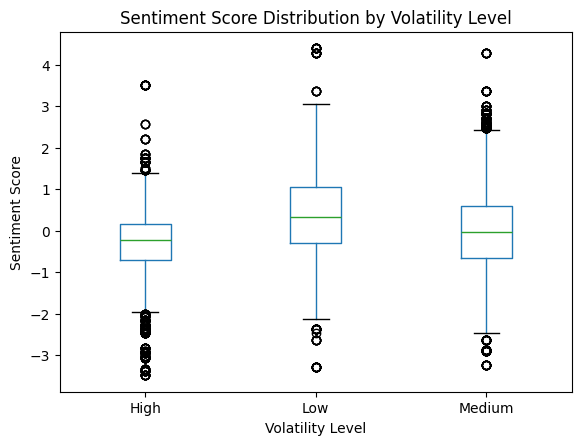

In [19]:
# Ensure nltk stopwords and potentially punkt are downloaded
# nltk.download('punkt') # Uncomment if needed

# 1. Compare Sentiment Distributions Across Volatility Levels
plt.figure()
data_merged.boxplot(column='sentiment_score', by='Volatility_Level', grid=False)
plt.title('Sentiment Score Distribution by Volatility Level')
plt.suptitle('')  # Remove default subtitle
plt.xlabel('Volatility Level')
plt.ylabel('Sentiment Score')
plt.show()

# This gives a quick visual clue if sentiment differs in distribution across volatility regimes.

Periods of high market volatility are associated with sentiment scores that cluster closer together, with fewer extreme deviations, possibly reflecting more uniformly uncertain or cautious sentiment.
Surprisingly, low volatility periods, which might be expected to correspond to calmer sentiment, actually exhibit a wider range and more extreme outliers. This suggests that when markets are stable, the narrative could diversify, producing a broader spectrum of sentiment.
Medium volatility sits in between, as expected, showing a moderate range and fewer extremes than the low volatility group.

In [20]:
'''# Ensure the DataFrame is sorted by date
data_merged = data_merged.sort_values(by="Date").reset_index(drop=True)

# Calculate log return for Next Day's Open vs. Today's Close
data_merged['log_return_open_close'] = np.log(data_merged['Open'].shift(-1) / data_merged['Close'])

# Calculate log return for Next Day's Close vs. Today's Close
data_merged['log_return_close_close'] = np.log(data_merged['Close'].shift(-1) / data_merged['Close'])

# Define thresholds for meaningful movement (e.g., 0.0005 for 0.05%)
threshold = 0.0005

# Create the movement variable for Next Day's Open vs. Today's Close
data_merged['movement_open_close'] = (data_merged['log_return_open_close'] > threshold).astype(int)

# Create the movement variable for Next Day's Close vs. Today's Close
data_merged['movement_close_close'] = (data_merged['log_return_close_close'] > threshold).astype(int)

# Drop the last row since it will have NaN in the log returns due to shift(-1)
data_merged = data_merged[:-1]

# Display the first few rows to confirm the calculation
print(data_merged[['Date', 'Close', 'Open', 'log_return_open_close', 'log_return_close_close', 
                   'movement_open_close', 'movement_close_close']].head())'''


'# Ensure the DataFrame is sorted by date\ndata_merged = data_merged.sort_values(by="Date").reset_index(drop=True)\n\n# Calculate log return for Next Day\'s Open vs. Today\'s Close\ndata_merged[\'log_return_open_close\'] = np.log(data_merged[\'Open\'].shift(-1) / data_merged[\'Close\'])\n\n# Calculate log return for Next Day\'s Close vs. Today\'s Close\ndata_merged[\'log_return_close_close\'] = np.log(data_merged[\'Close\'].shift(-1) / data_merged[\'Close\'])\n\n# Define thresholds for meaningful movement (e.g., 0.0005 for 0.05%)\nthreshold = 0.0005\n\n# Create the movement variable for Next Day\'s Open vs. Today\'s Close\ndata_merged[\'movement_open_close\'] = (data_merged[\'log_return_open_close\'] > threshold).astype(int)\n\n# Create the movement variable for Next Day\'s Close vs. Today\'s Close\ndata_merged[\'movement_close_close\'] = (data_merged[\'log_return_close_close\'] > threshold).astype(int)\n\n# Drop the last row since it will have NaN in the log returns due to shift(-1)\n